https://huggingface.co/docs/transformers/en/model_doc/vit

https://epfml.github.io/attention-cnn/

In [ ]:
import math
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import requests
from PIL import Image
from transformers import AutoModelForImageClassification, AutoImageProcessor

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224",
    use_fast=True,
)
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    torch_dtype=torch.float16,
    device_map=device,
    attn_implementation="eager"
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

D:\win-ws\DL-KHU\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--google--vit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

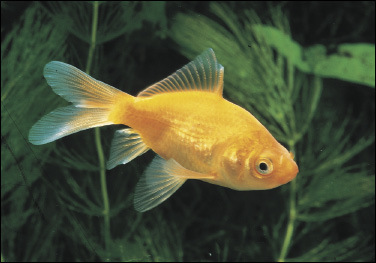

In [ ]:
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01443537_goldfish.JPEG?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
inputs = image_processor(image, return_tensors="pt").to(device)
inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [ ]:
with torch.inference_mode():
    outputs = model(**inputs, output_attentions=True)
type(outputs)

transformers.modeling_outputs.ImageClassifierOutput

In [ ]:
outputs.keys()

odict_keys(['logits', 'attentions'])

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 1000])

In [ ]:
predicted_class_id = logits.argmax(dim=-1).item()

class_labels = model.config.id2label
predicted_class_label = class_labels[predicted_class_id]
print(f"The predicted class label is: {predicted_class_label}")

The predicted class label is: goldfish, Carassius auratus


In [ ]:
attentions = outputs.attentions
print(type(attentions))
print(len(attentions))
attentions[0].shape    # (batch_size, num_heads, seq_len, seq_len)

<class 'tuple'>
12


torch.Size([1, 12, 197, 197])

In [ ]:
(224//16)

14

In [ ]:
14*14

196

torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 196])
torch.Size([1, 196])
torch.Size([1, 14, 14])
(224, 224)
(224, 224, 3)


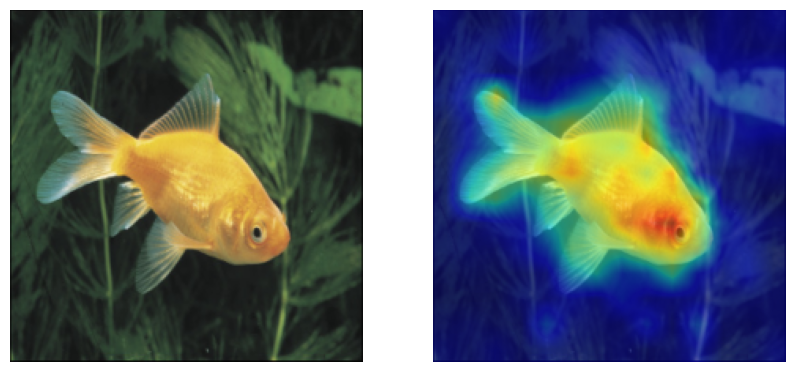

In [ ]:
attention_maps = attentions[4]
print(attention_maps.shape)

# select only the attention maps of the CLS token
attention_maps = attention_maps[:, :, 0, 1:]
print(attention_maps.shape)

# average the attention maps of the CLS token over all the heads
attention_maps = attention_maps.mean(dim=1)
print(attention_maps.shape)  # (batch_size, 14*14)

# reshape the attention maps to a square   
num_patches = attention_maps.size(-1)  
size = int(math.sqrt(num_patches)) 
attention_maps = attention_maps.view(-1, size, size) # (batch_size, 14, 14)
print(attention_maps.shape)

# resize the map to the size of the image
attention_maps = attention_maps.unsqueeze(1)
attention_maps = F.interpolate(attention_maps, size=(224, 224), mode='bilinear', align_corners=False)
attention_maps = attention_maps.squeeze().cpu().numpy()
print(attention_maps.shape)

# plot the images and the attention maps
img = inputs['pixel_values'].squeeze(0).permute(1, 2, 0).cpu().numpy()
img = img*image_processor.image_std + image_processor.image_mean
print(img.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(121)
ax.imshow(img)
ax.axis('off')
ax = fig.add_subplot(122)
ax.imshow(img)
ax.imshow(attention_maps, alpha=0.5, cmap='jet')
plt.axis('off')
plt.show()

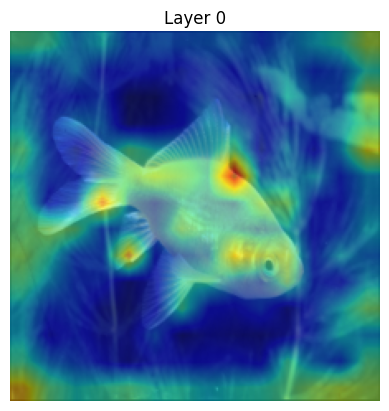

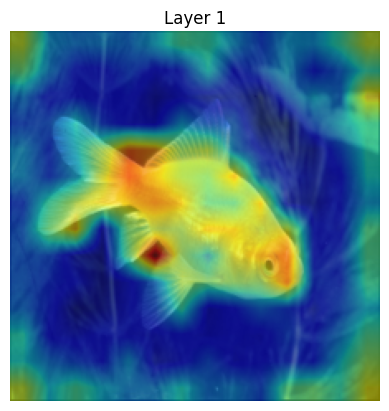

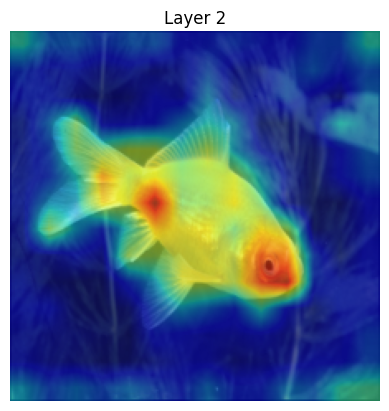

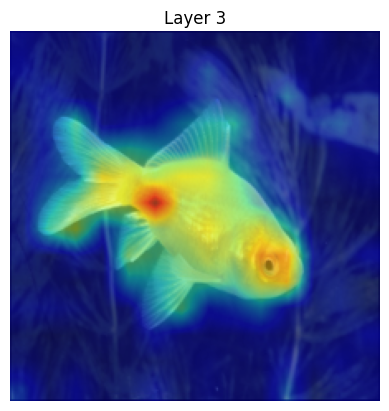

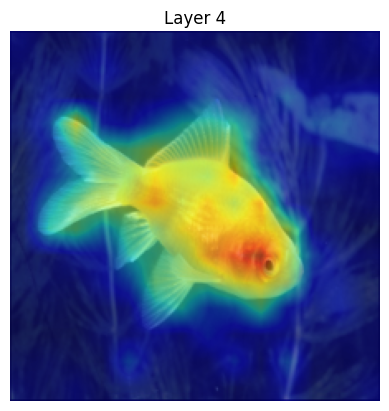

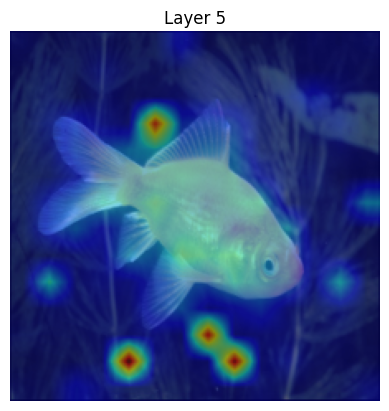

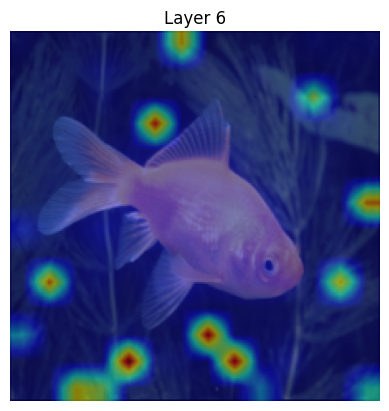

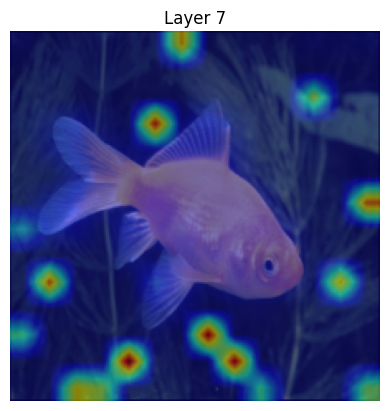

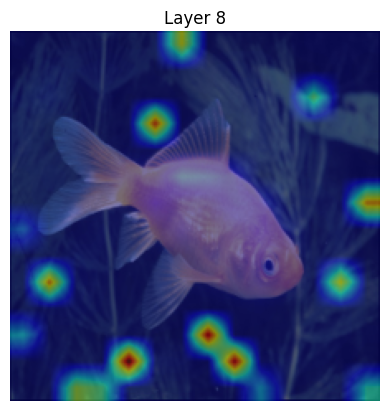

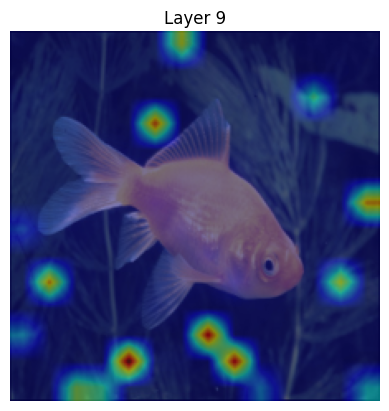

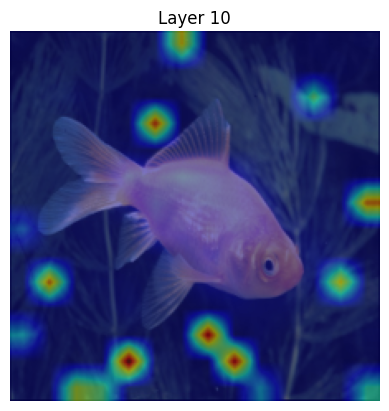

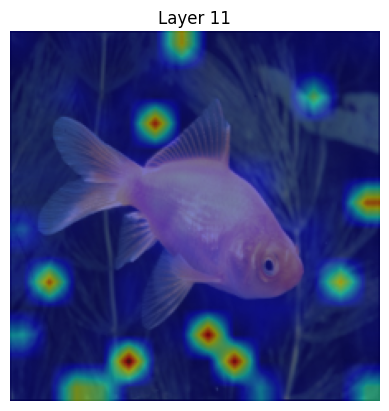

In [ ]:
for i in range(len(attentions)):
    attention_maps = attentions[i]
    attention_maps = attention_maps[:, :, 0, 1:]
    attention_maps = attention_maps.mean(dim=1)
    num_patches = attention_maps.size(-1)  
    size = int(math.sqrt(num_patches)) 
    attention_maps = attention_maps.view(-1, size, size) # (batch_size, 14, 14)
    attention_maps = attention_maps.unsqueeze(1)
    attention_maps = F.interpolate(attention_maps, size=(224, 224), mode='bilinear', align_corners=False)
    attention_maps = attention_maps.squeeze().cpu().numpy()

    img = inputs['pixel_values'].squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = img*image_processor.image_std + image_processor.image_mean

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(img)
    ax.imshow(attention_maps, alpha=0.5, cmap='jet')
    ax.set_title(f"Layer {i}")
    plt.axis('off')
    plt.show()